# Mountain Car Miniproject Tutorial Notebook

This notebook is here to guide you through the basics of the frameworks necessary for you to do well on your CS456-Miniproject 🤓

In [1]:
import os
import numpy as np
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import matplotlib.animation as animation
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import Patch
import json

env = gym.make('MountainCar-v0')

# get current working directory
print("Current working directory:", os.getcwd())

## Part 4 - Dyna

**4.1** State discretization
In the mountain car environment, the state ranges from [−1.2, −0.07] to [0.6, 0.07]. To create a discrete state space, we divide the state space into bins. The bin sizes should differ for the two state dimensions.


In [2]:
num_bins = np.array([18,14]) # position and velocity

def discretize_state(state, state_space, num_bins):
    bin_sizes = (state_space.high - state_space.low) / num_bins
    return ((state - state_space.low) / bin_sizes).astype(int), bin_sizes

state = np.array([-0.5, 0.03])
discrete_state,__ = discretize_state(state, env.observation_space, num_bins)
print(discrete_state)

[7 9]


**4.2 Model building**
During training, the agent builds a model of the environment consisting of two key components: an estimation of transition probabilities Pˆs,a(s′) and an estimation of the reward for each state-action pair Rˆ(s, a). Pˆs,a(s′) represents the expected probability of transitioning to state s′ after taking action a in state s, while Rˆ(s, a) is the expected reward when taking action a in state s. These estimates are updated with each new observation.

**4.3 Implementation**

In [ ]:
""" 1.1. Helper functions """

def plot_durations(episode_durations, run=1):
    durations_t = np.array(episode_durations)
    plt.title('Duration per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.scatter(np.arange(len(episode_durations)), durations_t, color='grey')
    
    moving_avg = []
    for i in range(len(episode_durations)):
        if i < 100:
            moving_avg.append(durations_t[:i+1].mean().item())  
        else:
            moving_avg.append(durations_t[i-99:i+1].mean().item()) 
    
    plt.plot(range(len(episode_durations)), moving_avg, color='orange', label='100-Moving Average')
    plt.legend()
    plt.savefig(f"DYNA_Duration_run_{run}.png", dpi=300)
    plt.close()
    
def plot_curve(data, title, xlabel, ylabel, run=1):
    plt.plot(data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(f"DYNA_{title}_run_{run}.png", dpi=300)
    plt.close()

def plot_curve_Q_R(data_Q, data_R, title, xlabel, ylabel, run=1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 8))
    ax[0].scatter(np.arange(len(data_Q)), data_Q)
    ax[0].set_title("Q-values")
    ax[0].set_xlabel("Steps")
    ax[0].set_ylabel("Q-values")
    ax[1].scatter(np.arange(len(data_R)), data_R)
    ax[1].set_title("R-values")
    ax[1].set_xlabel("Steps")
    ax[1].set_ylabel("R-values")

    plt.tight_layout()
    plt.savefig(f"DYNA_{title}_run_{run}.png", dpi=300)
    plt.close()

def plot_cumul_reward(data, xlabel, ylabel, run=1):
    plt.figure()
    data_t = np.array(data)
    plt.title('Cumulative Reward Per Episode')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(np.arange(len(data_t)), data_t, color='grey', label='Cumulative Reward Per Episode')

    if len(data_t) >= 100:
        window_size = 100
        means = np.convolve(data_t, np.ones(window_size) / window_size, mode='valid')
        plt.plot(np.arange(window_size-1, len(data_t)), means, color='orange', label='Moving Average (100 episodes)')

    plt.legend()
    plt.savefig(f"DYNA_Cumul_Reward_run_{run}.png", dpi=300)
    plt.close()

def plot_Q_for_each_action(agent, Q, env, title):
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    goal_position, goal_velocity = agent.discretize_state([env.goal_position, 0])[0], agent.discretize_state([env.goal_position, 0])[1]
    
    for i in range(3):
        im = ax[i].imshow(Q[:, :, i].T, cmap='viridis', interpolation='nearest', origin='lower')
        ax[i].set_xlabel('Position')
        ax[i].set_ylabel('Velocity')
        ax[i].set_title(f'Q-values for action {i}')
        ax[i].scatter(goal_position, goal_velocity, color='purple', label='Goal State')
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    
    fig.suptitle(title)
    plt.savefig(f"{title}.png", dpi=300)
    plt.close()

def plot_q_values(agent, Q_values, state_space, action_space, q=-1, run=1):
    max_Q = np.max(Q_values, axis=2)
    goal_position, goal_velocity = agent.discretize_state([env.goal_position, 0])[0], agent.discretize_state([env.goal_position, 0])[1]
    plt.figure(figsize=(10, 8))
    plt.title('Q-values')
    plt.imshow(max_Q.T, cmap='hot', interpolation='nearest', origin='lower')
    plt.scatter(goal_position, goal_velocity, color='red', label='Goal State')
    plt.colorbar(label='Q-value')
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.savefig(f"DYNA_Q_values_run_{run}_q_{q}.png", dpi=300)
    plt.close()


### Dyna-Agent

In [3]:
class DynaAgent:
    def __init__(self, state_space, action_space, discr_step=np.array([0.1, 0.01]), gamma=0.99, epsilon=0.9, k=10):
        self.discr_step = discr_step
        self.gamma = gamma
        self.state_space = state_space
        self.epsilon = epsilon 
        self.k = k
        self.nstates = ((state_space.high - state_space.low) / self.discr_step).astype(int) + 1 
        self.nactions = action_space.n
        self.P = np.ones((self.nstates[0], self.nstates[1], self.nactions, self.nstates[0], self.nstates[1])) / np.prod(self.nstates)
        self.R = np.zeros((self.nstates[0], self.nstates[1], self.nactions))
        self.Q = np.zeros((self.nstates[0], self.nstates[1], self.nactions))
        self.visits = np.zeros((self.nstates[0], self.nstates[1], self.nactions), dtype=int)
        self.learning_rate = 0.1
        self.position_list = []
        self.velocity_list = []
        self.delta_Q = []
        self.delta_t = 0.1
        self.q_value_updates = []

    def discretize_state(self, state):
        return ((state - self.state_space.low) / self.discr_step).astype(int)
    
    def update_model(self, s, a, r, s_prime):
        s_discrete = s
        s_prime_discrete = s_prime
        self.visits[s_discrete[0], s_discrete[1], a] += 1
        self.learning_rate = 1 / self.visits[s_discrete[0], s_discrete[1], a]
        self.R[s_discrete[0], s_discrete[1], a] += self.learning_rate * (r - self.R[s_discrete[0], s_discrete[1], a])
        self.P[s_discrete[0], s_discrete[1], a, s_prime_discrete[0], s_prime_discrete[1]] += self.learning_rate
        self.P[s_discrete[0], s_discrete[1], a] /= np.sum(self.P[s_discrete[0], s_discrete[1], a])

    def update_Q_value(self, s, a):
        s_discrete = s
        future_rewards = self.P[s[0], s[1], a] * np.max(self.Q, axis=2)
        self.q_value_updates.append(self.R[s_discrete[0], s_discrete[1], a] + self.gamma * np.sum(future_rewards) - self.Q[s_discrete[0], s_discrete[1], a]) 
        self.Q[s_discrete[0], s_discrete[1], a] = self.R[s_discrete[0], s_discrete[1], a] + self.gamma * np.sum(future_rewards)
    
    def simulate(self):
        s_prime = np.zeros(2, dtype=int)
        for _ in range(self.k):
            visited_states = np.where(self.visits > 0)
            idx = np.random.choice(len(visited_states[0]))
            s = (visited_states[0][idx], visited_states[1][idx])
            a = visited_states[2][idx]
            transition_probs = self.P[s[0], s[1], a] / np.sum(self.P[s[0], s[1], a])
            mat = np.repeat(np.arange(self.nstates[0])[:, np.newaxis], self.nstates[1], axis=1)
            chosen_index = np.random.choice(mat.flatten(), p=transition_probs.flatten())
            s_prime = np.unravel_index(chosen_index, shape=self.nstates)
            reward = self.R[s[0], s[1], a]
            max_q_next = np.max(self.Q[s_prime[0], s_prime[1]])
            self.Q[s[0], s[1], a] += self.learning_rate * (reward + self.gamma * max_q_next - self.Q[s[0], s[1], a])

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return env.action_space.sample()
        else:
            s_discrete = state
            return np.argmax(self.Q[s_discrete[0], s_discrete[1]])

    def decay_epsilon(self):
        self.epsilon *= 0.99
        self.epsilon = max(self.epsilon, 0.05)


In [7]:
run_id = 1
# for trianing
state_space = env.observation_space
action_space = env.action_space
agent = DynaAgent(state_space, action_space)

# for evaluation
# Open the file
with open('/Users/mariayuffa/mountain_car/seeds.json', 'r') as file:
    seeds = json.load(file)
#print(len(seeds))

def train(agent, env):
    store = {'Q': [], 'Q_avg':[], 'R': [], 'action': [], 'state': [], 'rewards': [], 'delta_Q': [], 'episode_durations': [], 'agent_performance': [], 'trajectories': []}
    for episode in range(3000):
        state, _ = env.reset()
        state = agent.discretize_state(state)
        total_reward = 0
        done = False
        trajectory = []
        running_Q = np.zeros((agent.nstates[0], agent.nstates[1], agent.nactions))
        while not done:
            store['Q'].append(agent.Q.copy())
            store['R'].append(agent.R.copy())
            running_Q += agent.Q.copy()
            action = agent.choose_action(state)
            store['action'].append(action)
            next_state, reward, terminated, truncated, _ = env.step(action)
            trajectory.append(next_state)
            next_state = agent.discretize_state(next_state)
            store['state'].append(next_state)
            
            agent.update_Q_value(state, action)
            agent.update_model(state, action, reward, next_state)
            store['delta_Q'].append(np.mean(agent.Q.copy()) - np.mean(store['Q'][-1]))
            
            agent.simulate()

            total_reward += reward
            state = next_state

            done = terminated or truncated
            if done:
                store['episode_durations'].append(-total_reward)
                store['Q_avg'].append(running_Q / len(trajectory))
                if terminated:
                    store['agent_performance'].append(1)
                else:
                    store['agent_performance'].append(0)
                break
        store['rewards'].append(total_reward)
        store['trajectories'].append(trajectory)
        agent.decay_epsilon()
        print(f"Episode {episode + 1}: {total_reward}")
    return store


def evaluate(agent, env, seeds):
    store = {'Q': [], 'Q_avg':[], 'R': [], 'action': [], 'state': [], 'rewards': [], 'delta_Q': [], 'episode_durations': [], 'agent_performance': [], 'trajectories': []}
    for episode in range(len(seeds)):
        env.reset()
        state = seeds[episode]
        state = agent.discretize_state(state)
        total_reward = 0
        done = False
        trajectory = []
        running_Q = np.zeros((agent.nstates[0], agent.nstates[1], agent.nactions))
        while not done:
            store['Q'].append(agent.Q.copy())
            store['R'].append(agent.R.copy())
            running_Q += agent.Q.copy()
            action = np.argmax(agent.Q[state[0], state[1]])  # Greedy policy
            store['action'].append(action)
            next_state, reward, terminated, truncated, _ = env.step(action)
            trajectory.append(next_state)
            next_state = agent.discretize_state(next_state)
            store['state'].append(next_state)
            
            store['delta_Q'].append(np.mean(agent.Q.copy()) - np.mean(store['Q'][-1]))
            
            total_reward += reward
            state = next_state

            done = terminated or truncated
            if done:
                store['episode_durations'].append(-total_reward)
                store['Q_avg'].append(running_Q / len(trajectory))
                if terminated:
                    store['agent_performance'].append(1)
                else:
                    store['agent_performance'].append(0)
                break
        store['rewards'].append(total_reward)
        store['trajectories'].append(trajectory)
        print(f"Evaluation Episode {episode + 1}: {total_reward}")
    env.close()
    return store

store_train = train(agent, env)


Episode 1: -200.0
Episode 2: -200.0
Episode 3: -200.0
Episode 4: -200.0
Episode 5: -200.0
Episode 6: -200.0
Episode 7: -200.0
Episode 8: -200.0
Episode 9: -200.0
Episode 10: -200.0
Episode 11: -200.0
Episode 12: -200.0
Episode 13: -200.0
Episode 14: -200.0
Episode 15: -200.0
Episode 16: -200.0
Episode 17: -200.0
Episode 18: -200.0
Episode 19: -200.0
Episode 20: -200.0
Episode 21: -200.0
Episode 22: -200.0
Episode 23: -200.0
Episode 24: -200.0
Episode 25: -200.0
Episode 26: -200.0
Episode 27: -200.0
Episode 28: -200.0
Episode 29: -200.0
Episode 30: -200.0
Episode 31: -200.0
Episode 32: -200.0
Episode 33: -200.0
Episode 34: -200.0
Episode 35: -200.0
Episode 36: -200.0
Episode 37: -200.0
Episode 38: -200.0
Episode 39: -200.0
Episode 40: -200.0
Episode 41: -200.0
Episode 42: -200.0
Episode 43: -200.0
Episode 44: -200.0
Episode 45: -200.0
Episode 46: -200.0
Episode 47: -200.0
Episode 48: -200.0
Episode 49: -200.0
Episode 50: -200.0
Episode 51: -200.0
Episode 52: -200.0
Episode 53: -200.0
Ep

In [10]:
store_eval = evaluate(agent, env, seeds)

Evaluation Episode 1: -152.0
Evaluation Episode 2: -177.0
Evaluation Episode 3: -134.0
Evaluation Episode 4: -179.0
Evaluation Episode 5: -155.0
Evaluation Episode 6: -196.0
Evaluation Episode 7: -180.0
Evaluation Episode 8: -157.0
Evaluation Episode 9: -182.0
Evaluation Episode 10: -182.0
Evaluation Episode 11: -178.0
Evaluation Episode 12: -197.0
Evaluation Episode 13: -180.0
Evaluation Episode 14: -190.0
Evaluation Episode 15: -157.0
Evaluation Episode 16: -156.0
Evaluation Episode 17: -157.0
Evaluation Episode 18: -145.0
Evaluation Episode 19: -148.0
Evaluation Episode 20: -183.0
Evaluation Episode 21: -141.0
Evaluation Episode 22: -160.0
Evaluation Episode 23: -197.0
Evaluation Episode 24: -190.0
Evaluation Episode 25: -181.0
Evaluation Episode 26: -188.0
Evaluation Episode 27: -182.0
Evaluation Episode 28: -160.0
Evaluation Episode 29: -130.0
Evaluation Episode 30: -178.0
Evaluation Episode 31: -179.0
Evaluation Episode 32: -181.0
Evaluation Episode 33: -179.0
Evaluation Episode 

In [11]:
# store environment rewards
with open('dyna_environment_reward.json', 'w') as f:
    json.dump(store_train['rewards'], f)

# store the episode durations
episode_durations = store_train['episode_durations']
with open('dyna_episode_durations.json', 'w') as file:
    json.dump(episode_durations, file)

# store the episode durations during testing
episode_durations_eval = store_eval['episode_durations']
with open('dyna_episode_durations_testing.json', 'w') as file:
    json.dump(episode_durations_eval, file)

In [12]:
# Plotting
# plot for question 3
plot_durations(store_train['episode_durations'])
plot_curve([np.sum(store_train['agent_performance'][:i]) for i in range(len(store_train['agent_performance']))], 'Agent Performance', 'Episode', 'Performance')

plot_curve_Q_R([np.mean(q) for q in store_train['Q']], [np.mean(r) for r in store_train['R']], 'Q and R Values', 'Steps', 'Values')
plot_cumul_reward(store_train['rewards'], 'Episode', 'Cumulative Reward')

# plot for question 6
plot_Q_for_each_action(agent, agent.Q, env, f'Q-values for each action {-1}')
plot_Q_for_each_action(agent, store_train["Q_avg"][-1500], env, f'Q-values for each action {-1500}')

# Plot Q-values for the best action
# plot for question 6
plot_q_values(agent, agent.Q, state_space, action_space, q=-1)
#plot_q_values(store["Q"][-1500], state_space, action_space , q=-1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [13]:
def plot_cumul_reward(data, xlabel, ylabel, run=1):
    plt.figure()
    data_t = np.array(data)
    plt.title('Q-values')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(np.arange(len(data_t)), data_t, color='grey', s=2, label='Average Q-value per episode')

    if len(data_t) >= 100:
        window_size = 100
        means = np.convolve(data_t, np.ones(window_size) / window_size, mode='valid')
        plt.plot(np.arange(window_size-1, len(data_t)), means, color='orange', label='Moving Average (100 episodes)')

    plt.legend()
    plt.savefig(f"DYNA_Cumul_Reward_run_{run}.png", dpi=300)
    plt.close()
    plt.show()

plot_cumul_reward(agent.q_value_updates, 'Steps', 'Q-value difference', run=4)
plot_cumul_reward([np.mean(store_train['Q_avg'][i]-store_train['Q_avg'][i-1]) for i in range(len(store_train['Q_avg'])) if i > 0], 'Steps', 'Q-value difference', run=22)

In [94]:
# plot for question 7
def plot_trajectories(Q_values, state_space, trajectories, labels, run=1):
    max_Q = np.max(Q_values, axis=2)
    fig, ax = plt.subplots(figsize=(20, 15))
    ax.set_title('Q-values with Trajectories')
    
    # Set the correct extent for the axes
    extent = [state_space.low[0], state_space.high[0], state_space.low[1], state_space.high[1]]

    # Plot the Q-values
    im = ax.imshow(max_Q.T, cmap='hot', interpolation='nearest', 
                   extent=extent, origin='lower')
    fig.colorbar(im, ax=ax, label='Q-value')
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    
    # Rescale the y-axis to match the x-axis
    ax.set_aspect((state_space.high[0] - state_space.low[0]) / (state_space.high[1] - state_space.low[1]), adjustable='box')

    # Set y-axis ticks and labels to keep them between -0.07 and 0.07
    ax.set_yticks(np.linspace(state_space.low[1], state_space.high[1], num=5))
    ax.set_yticklabels(np.linspace(-0.07, 0.07, num=5))
    
    # Plot the trajectories
    for i,trajectory in enumerate(trajectories):
        positions, velocities = zip(*trajectory)
        ax.plot(positions, velocities, marker='o', markersize=2, linestyle='-', label=f'Trajectory {labels[i]}')
    ax.legend()
    fig.savefig(f"DYNA_Q_values_trajectories_run_{run}.png", dpi=300)
    plt.close(fig)

# Plot Trajectories
plot_trajectories(agent.Q, state_space, [store_train['trajectories'][i] for i in range(0, len(store_train['trajectories']), 300)], [i for i in range(0,3000,300)], run=1)


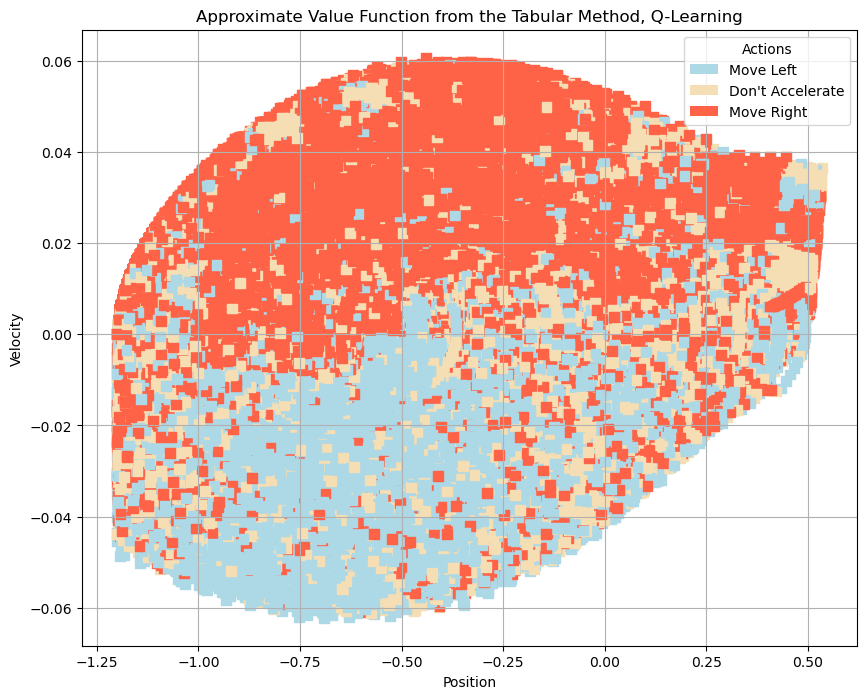

In [47]:
actions = np.array(store_train['action'])  # Randomly chosen actions for illustration
stacked_states = np.stack(store_train['state'])

# Map actions to colors
color_map = {0: 'lightblue', 1: 'wheat', 2: 'tomato'}  # Assume 0: Move Left, 1: Don't Accelerate, 2: Move Right
colors = np.empty(len(actions), dtype=object)  # Use dtype=object to store color names
for action, color in color_map.items():
    colors[actions == action] = color

# Create the plot
plt.figure(figsize=(10, 8))
#plt.scatter(stacked_states[:,0], stacked_states[:,1], c=colors.flatten(), marker='s', s=100)  # Flatten arrays
plt.scatter(agent.position_list[1:], agent.velocity_list[1:], c=colors.flatten(), marker='s', s=50)  # Flatten arrays

# Create a custom legend for actions
legend_elements = [Patch(facecolor=color_map[key], label=label) for key, label in {0: 'Move Left', 1: "Don't Accelerate", 2: 'Move Right'}.items()]
plt.legend(handles=legend_elements, title="Actions")

plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Approximate Value Function from the Tabular Method, Q-Learning')
plt.grid(True)
plt.show()


**BONUS**

In [22]:
def plot_q_progression(store_train, run_id):
    # Plot Q-value updates
    plt.figure(figsize=(10, 6))
    plt.plot([np.mean(q) for q in store_train['Q']], marker='o', linestyle='-', markersize=1)
    plt.title('Q-values')
    plt.xlabel('Step')
    plt.ylabel('Q-value Update')
    plt.grid()
    plt.savefig(f"DYNA_Q_values_bonus_run_{run_id}.png", dpi=300)
    plt.close()

plot_q_progression(store_train)

In [13]:
fig, ax = plt.subplots(4, 3, figsize=(20, 15))  # Adjusted figsize to make subplots larger
k = 0

# Create a colorbar axis
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]

for i in range(0, len(store_train["Q_avg"]), 250):
    max_Q = np.max(store_train["Q_avg"][i], axis=2)
    goal_position, goal_velocity = agent.discretize_state([env.goal_position, 0])[0], agent.discretize_state([env.goal_position, 0])[1]
    
    im = ax[k // 3, k % 3].imshow(max_Q.T, cmap='hot', interpolation='nearest', origin='lower')
    ax[k // 3, k % 3].scatter(goal_position, goal_velocity, color='red', label='Goal State')
    ax[k // 3, k % 3].set_title(f'Snapshot {i}')
    ax[k // 3, k % 3].legend()

    k += 1

# Add a single colorbar for the whole figure
fig.colorbar(im, cax=cbar_ax, label='Q-value')

fig.tight_layout(rect=[0, 0.03, 0.9, 0.95])  # Adjust rect to leave space for colorbar
fig.suptitle('Q-values', fontweight='bold', fontsize=20)
fig.supxlabel('Position', fontweight='bold', fontsize=16)
fig.supylabel('Velocity', fontweight='bold', fontsize=16)
plt.savefig(f"/Users/mariayuffa/mountain_car-1/dyna/plots/DYNA_Q_values_plots_bonus_run_{run_id}.png", dpi=300)
plt.close()
plt.show()


/var/folders/mg/44g5ch495hdc8x4_5mq3dsdm0000gn/T/ipykernel_26593/1926092625.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 0.9, 0.95])  # Adjust rect to leave space for colorbar
